## Install the necessary libraries

In [ ]:
!pip install tensorflow pandas numpy matplotlib sklearn seaborn

# Importing all the necessary libraries
Import necessary libraries such as pandas, numpy, matplotlib, seaborn, and
TensorFlow's Keras module, enabling data manipulation, visualization etc..

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Data Reading and Manipulation

In [2]:
# Read the dataset
data = pd.read_csv('/content/dataset_phishing.csv')

data['status'] = data['status'].replace('legitimate', 1)
data['status'] = data['status'].replace('phishing', 0)

# Data Visualization
## Pie chart for checking any imbalance

<Axes: ylabel='status'>

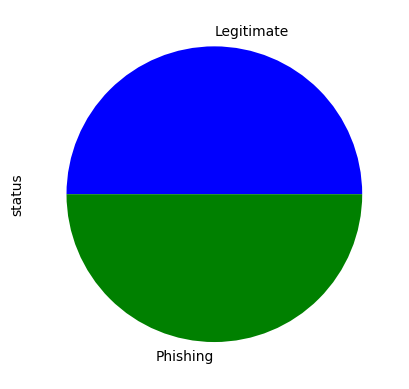

In [3]:
data['status'].value_counts().plot(kind = 'pie', colors = ['blue', 'green'], labels=['Legitimate', 'Phishing'])

## Train-Test Data Separation


In [4]:
X = data.drop(['url', 'status'], axis = 1).astype(int)
Y = data['status'].astype(int)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state = 42)
np.save("X_train.npy", X_train)
np.save("Y_train.npy", Y_train)
np.save("X_test.npy", X_test)
np.save("Y_test.npy", Y_test)

## Correlation matrix

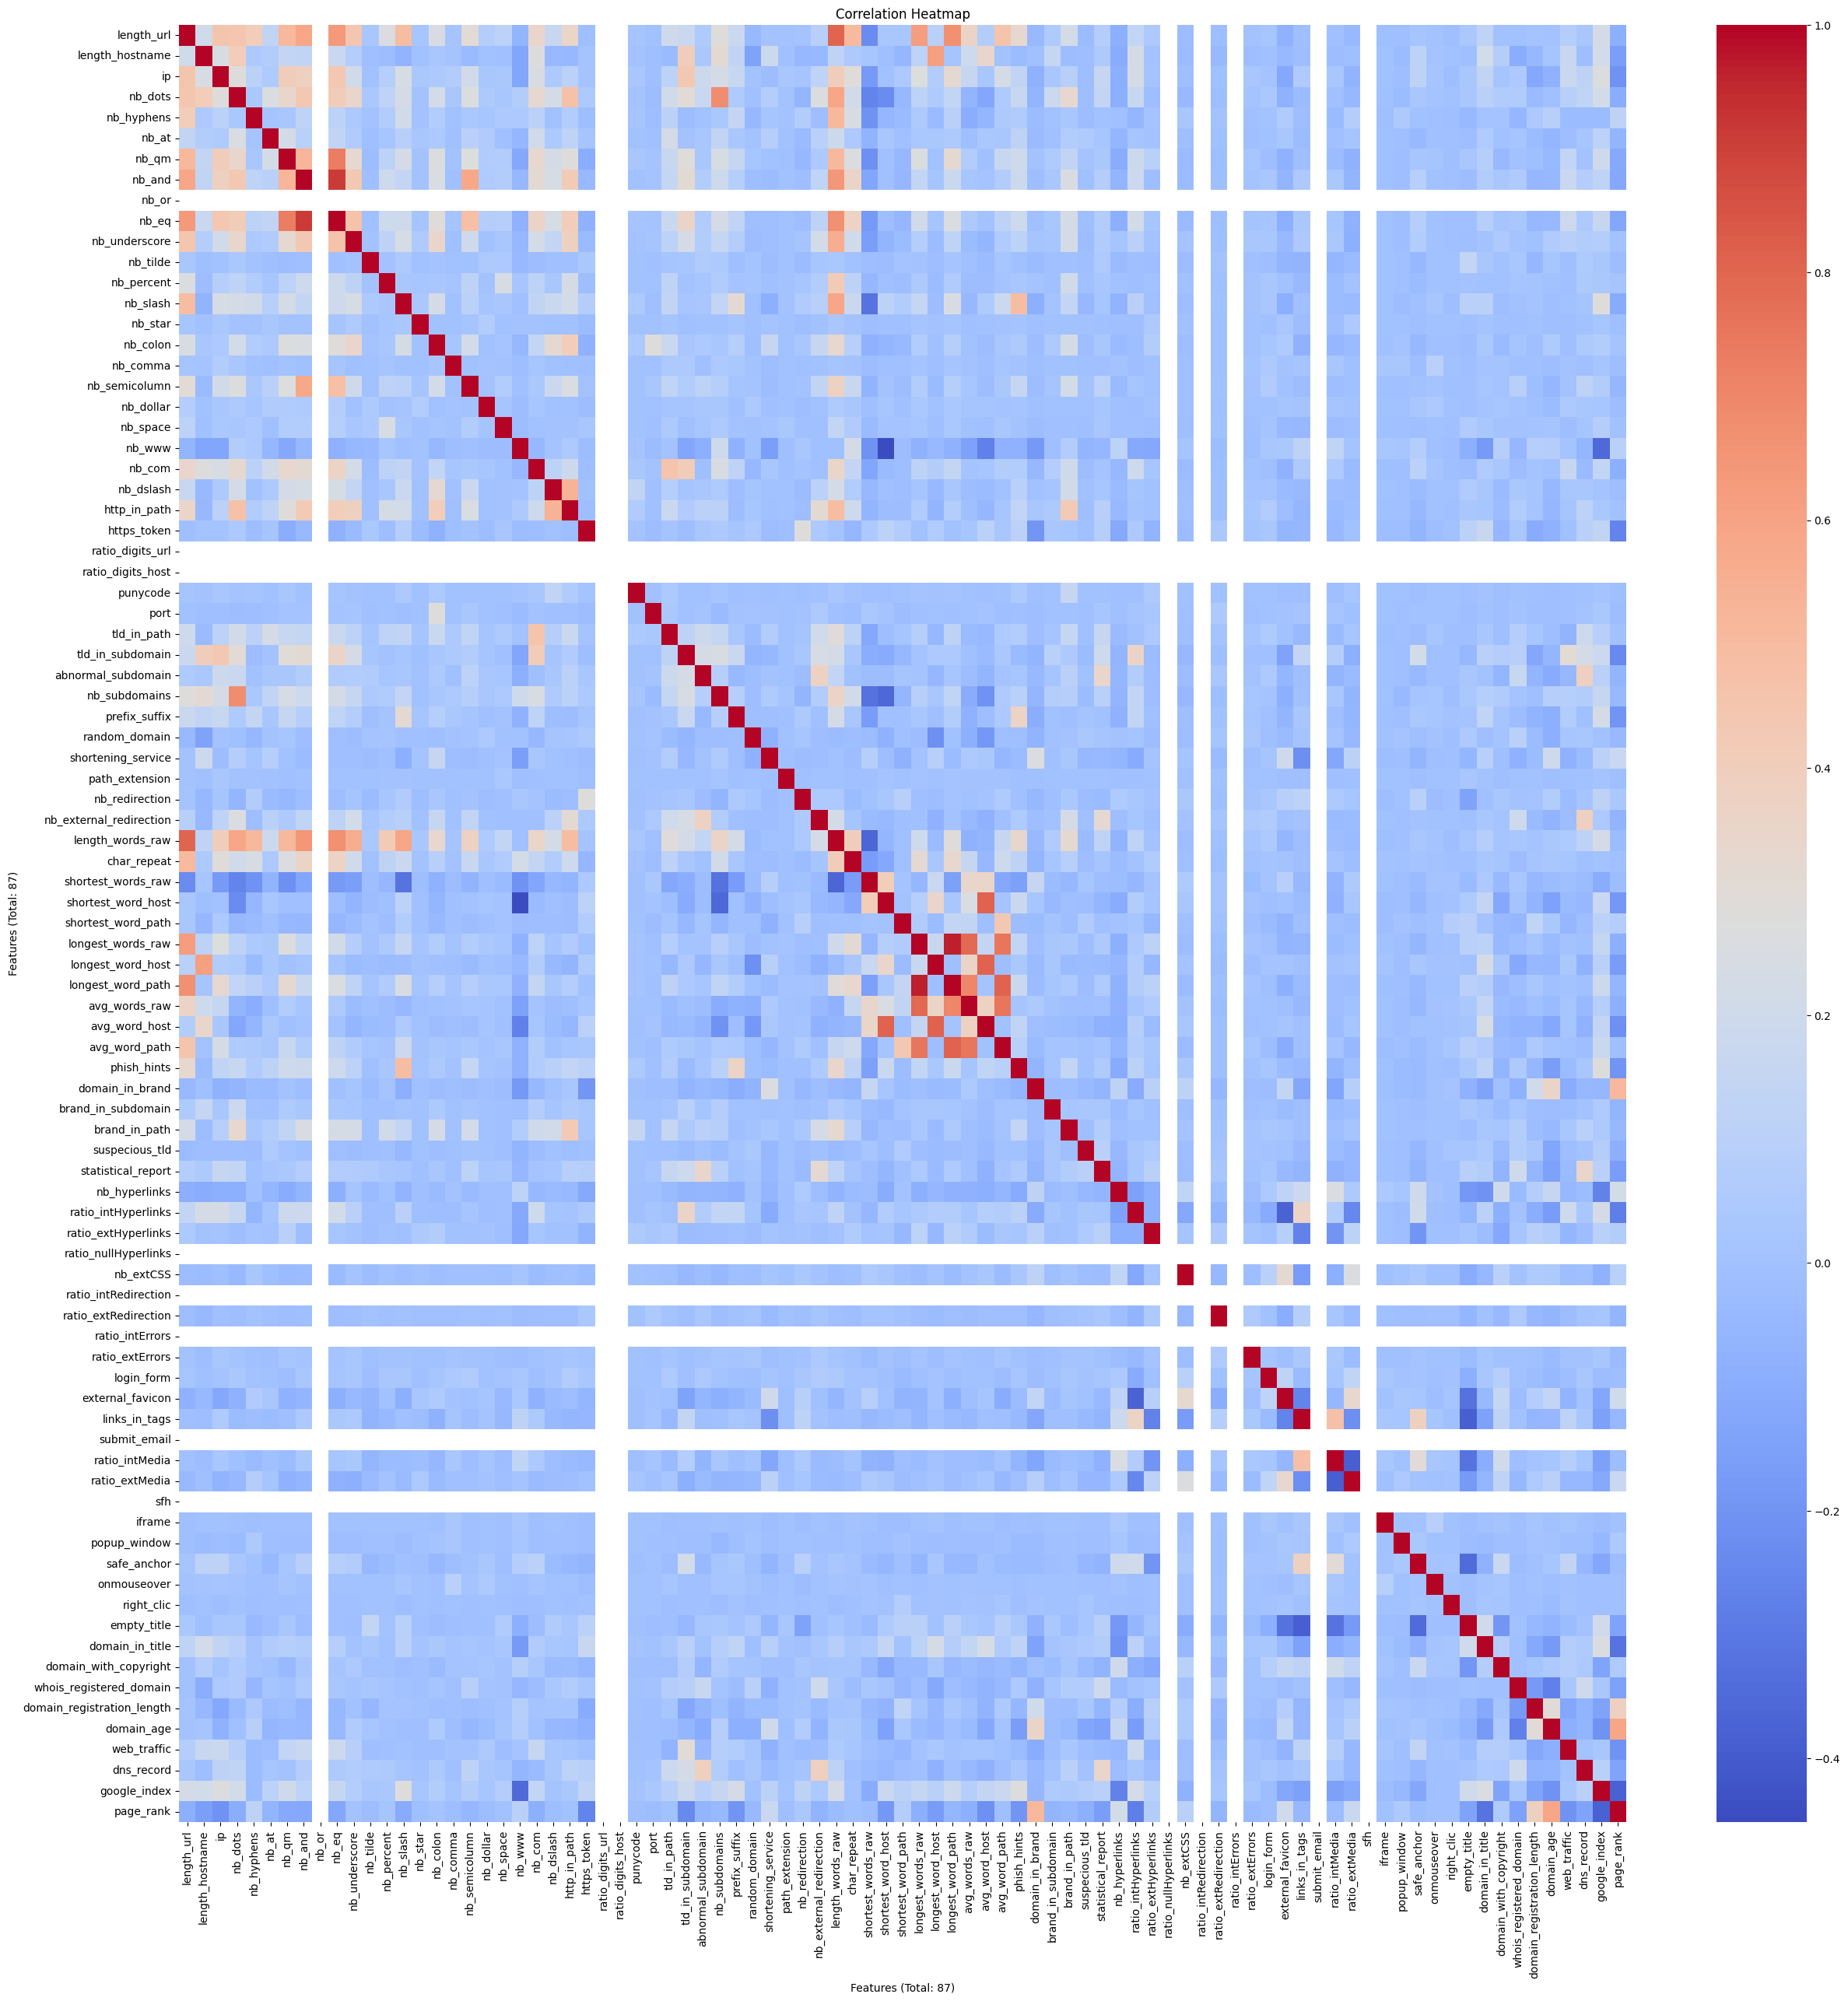

In [5]:
mat = X_train.corr()
plt.figure(figsize=(30, 30))
sns.heatmap(mat, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.xlabel(f'Features (Total: {mat.shape[1]})')
plt.ylabel(f'Features (Total: {mat.shape[1]})')
plt.show()

## Plotting the important features


In [6]:
imp_features = [
    ['length_url', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_dslash', 'nb_redirection'],
    ['nb_semicolumn', 'nb_www', 'nb_dollar', 'domain_in_title', 'https_token', 'ratio_digits_url', 'iframe'],
    ['nb_comma', 'http_in_path', 'domain_with_copyright', 'domain_age', 'domain_registration_length', 'phish_hints', 'brand_in_path'],
    ['shortest_words_raw', 'shortest_word_host', 'shortest_word_path', 'longest_words_raw', 'longest_word_host', 'longest_word_path'],
    ['avg_words_raw', 'avg_word_host', 'avg_word_path', 'domain_in_brand', 'ratio_intHyperlinks', 'ratio_extHyperlinks', 'ratio_nullHyperlinks']
]

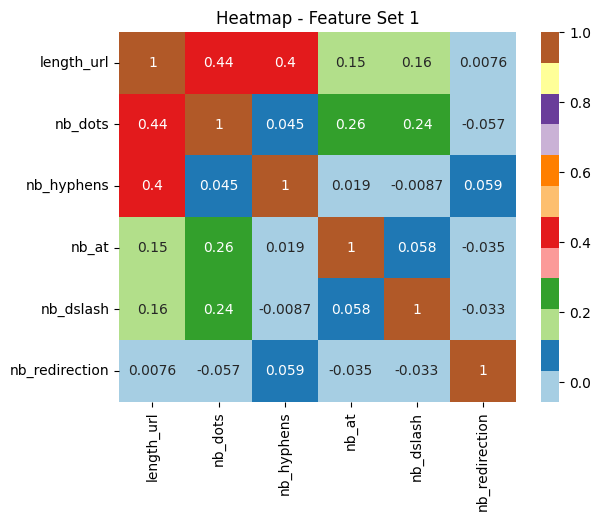

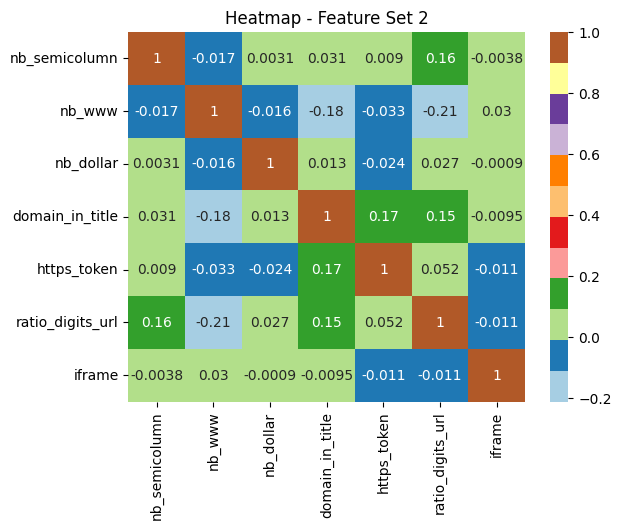

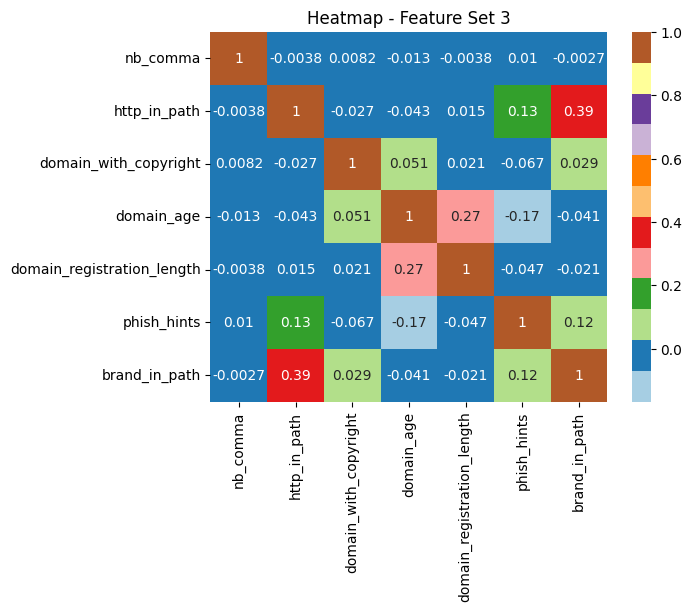

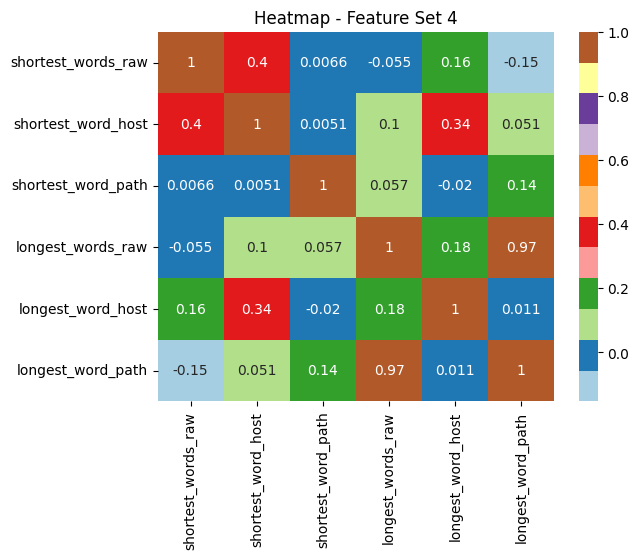

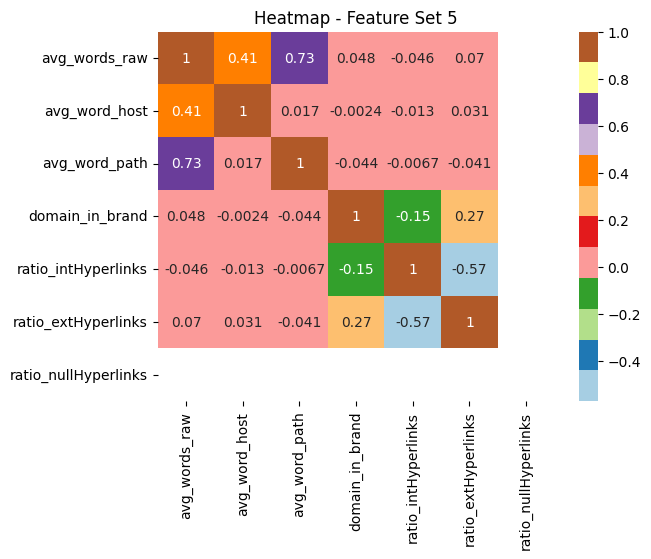

In [7]:
for i, features in enumerate(imp_features):
    df = data[features]
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix, annot=True, cbar = True, cmap = 'Paired')
    plt.title(f"Heatmap - Feature Set {i+1}")
    plt.show()

## Model Architecture
The model architecture combines a 1D Convolutional Neural Network (CNN) and Long Short-Term Memory (LSTM). The main reason for including the LSTM layer is to identify relevant recurring patterns in the data. The model is built using the Keras library with a sequential structure.



In [8]:
# Build the model
model = keras.Sequential([
    keras.layers.Conv1D(filters=64, input_shape=(87,1), kernel_size=2, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),

    keras.layers.LSTM(100),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation = 'sigmoid'),
    keras.layers.Dense(512, activation='sigmoid'),
    keras.layers.Dense(64, activation = 'sigmoid'),
    keras.layers.Dense(2, activation='sigmoid'),
])


## Defining Loss and Metrics for Model
The loss function used here is sparse categorical cross entropy, which returns one-hot encodings.

In [9]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Model training
The model is trained with 100 epochs, with the default batch size.

In [10]:
history = model.fit(X_train, Y_train, epochs=100)

Epoch 1/100
251/251 [==============================] - 16s 49ms/step - loss: 0.4071 - accuracy: 0.8038
Epoch 2/100
251/251 [==============================] - 12s 47ms/step - loss: 0.2477 - accuracy: 0.9045
Epoch 3/100
251/251 [==============================] - 11s 45ms/step - loss: 0.2346 - accuracy: 0.9109
Epoch 4/100
251/251 [==============================] - 12s 47ms/step - loss: 0.2189 - accuracy: 0.9185
Epoch 5/100
251/251 [==============================] - 12s 48ms/step - loss: 0.2057 - accuracy: 0.9235
Epoch 6/100
251/251 [==============================] - 12s 48ms/step - loss: 0.1929 - accuracy: 0.9273
Epoch 7/100
251/251 [==============================] - 12s 48ms/step - loss: 0.1879 - accuracy: 0.9301
Epoch 8/100
251/251 [==============================] - 12s 48ms/step - loss: 0.1687 - accuracy: 0.9405
Epoch 9/100
251/251 [==============================] - 12s 48ms/step - loss: 0.1636 - accuracy: 0.9394
Epoch 10/100
251/251 [==============================] - 12s 48ms/step - l

## Plotting accuracy vs epoch graph

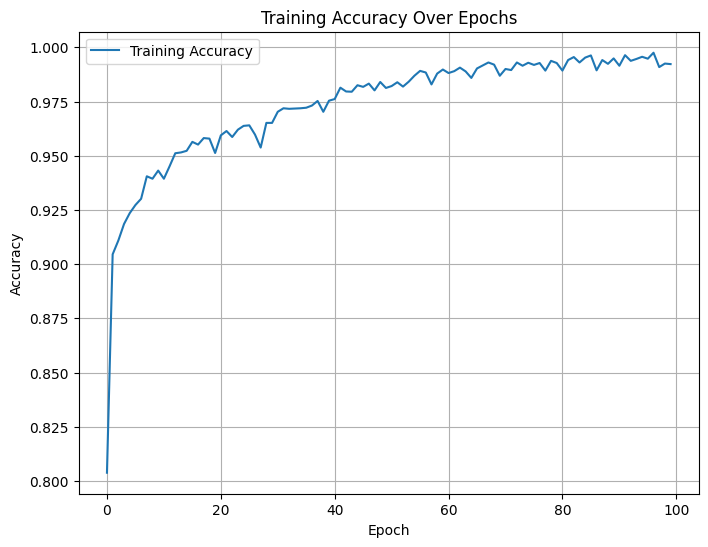

In [35]:
np.save("history.npy", history)
accuracy = history.history['accuracy']

# Create a plot
plt.figure(figsize=(8, 6))
plt.plot(accuracy, label='Training Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Model summary


In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 86, 64)            192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 43, 64)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 100)               66000     
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 64)                6464      
                                                                 
 dense_1 (Dense)             (None, 512)               33280     
                                                        

## Saving the model
Saving the model helps in avoid re-training and can be used multiple times

In [37]:
model.save("my_model.h5")

## Quantifying Misclassifications
The number of misclassifications by the model, for the training data.

In [38]:
Y_pred = model.predict(X_train)
cnt = 0
for i in range(len(Y_pred)):
    if(np.argmax(Y_pred[i]) != np.array(Y_train)[i]):
      cnt = cnt + 1
print(cnt)

251/251 [==============================] - 4s 14ms/step
66


## Testing the model
model.evaulate() is an inbuilt function that helps us evaluate the test accuracy.

In [39]:
from keras import models
model = models.load_model("my_model.h5")
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(test_accuracy)

108/108 [==============================] - 2s 15ms/step - loss: 0.1866 - accuracy: 0.9533
0.953339159488678


## Classification report generation


In [40]:
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)

report = classification_report(Y_test, Y_pred_classes)
print(report)

108/108 [==============================] - 2s 16ms/step
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1697
           1       0.95      0.96      0.95      1732

    accuracy                           0.95      3429
   macro avg       0.95      0.95      0.95      3429
weighted avg       0.95      0.95      0.95      3429



## Confusion matrix

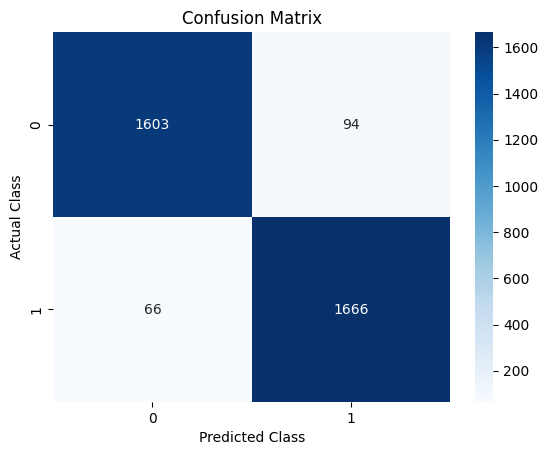

In [41]:
cm = confusion_matrix(Y_test, Y_pred_classes)
fig, ax = plt.subplots()

sns.heatmap(cm, fmt = 'd', annot=True, cmap='Blues', ax=ax)

ax.set_xlabel('Predicted Class')
ax.set_ylabel('Actual Class')
ax.set_title('Confusion Matrix')


plt.show()

In [42]:
from sklearn.metrics import roc_curve, roc_auc_score
from keras import models
model = models.load_model("my_model.h5")

## Receiver Operating Characteristic (ROC) Curve

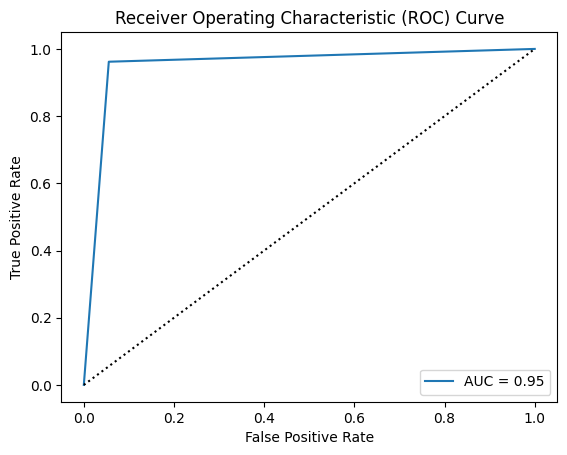

In [43]:
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_classes)
auc = roc_auc_score(Y_test, Y_pred_classes)

plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k:')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()